Here we'll introduce some of the functionality of a sub-module for working with Kepler K2 fields.  There is an official k2fov package created by the Kepler team, but I wrote this before learning about it, and so much functionality of other parts of the library is based on this sub-module.  It's pretty straight forward to use, and offers some utilities for determining object locations on the Kepler CCD.  So let's get to it.

First, let's import the module.

In [2]:
from utilities import k2fov

We create an instance of a K2 field by instantiating a `Field` class with a campaign.  We'll use the campaign 8 field of view in this example.

In [3]:
c8fov = k2fov.Field(8)

We can plot the outline of the field on the sky by using the `plot_field` method and passing in a `matplotlib` `Axes` instance.

In [7]:
%matplotlib inline
from matplotlib.pyplot import subplots
import richardsplot as rplot

Text(0,0.5,u'DEC')

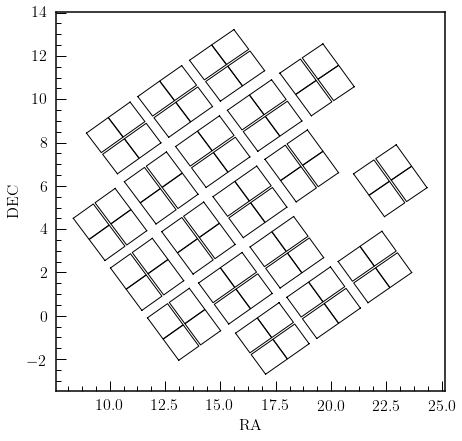

In [8]:
fig, ax = subplots(1,1)
c8fov.plot_field(ax)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

Now let's use the module to inspect a little information about the location of an object.  For this, we'll look at an AGN in campaign 8: `EPIC 220282234` at 01:29:18.546+02:15:19.94	

In [16]:
ra_hms = '01 29 18.546'
dec_dms = '+02 15 19.94'
coord_sgml = " ".join((ra_hms, dec_dms))
print coord_sgml

01 29 18.546 +02 15 19.94


The class requires coordinates to be in degrees, so we'll use astropy to convert our coordinates.

In [17]:
from astropy import units
from astropy.coordinates import SkyCoord

In [20]:
coord = SkyCoord(coord_sgml, unit=(units.hourangle, units.deg))
print coord

<SkyCoord (ICRS): (ra, dec) in deg
    ( 22.327275,  2.25553889)>


Now we can test whether or not a point exists within the field of view of K2 campaign 8.  We use the `test_point` method, which will return an ordered pair of module and channel number.  Since the K2 modules starts at `1`, a result of `(0, 0)` means the object does not exist within the field of view.

In [21]:
module, channel = c8fov.test_point(coord.ra.degree, coord.dec.degree)
print module, channel

6 15


So now we know our object is in module 6, channel 15.  Sometimes, channels are indexed relative to their module (each module has 4 channels, indexed 1-4) so we can figure out which channel `15` represents relative to module 6.  We use the `get_channels` method and pass the module we would like to list the channels for.  Then we find the index of the channel we were given by the `test_point` method.

In [24]:
module6_channels = c8fov.get_channels(6)
print module6_channels
print module6_channels.index(channel)+1

[13, 14, 15, 16]
3


So we can see that channel 15 is the third channel in module 6.  In some literature, you may see this represented as module 6.3 or 6-3.

On the reverse, we can look at which module an arbitrary channel belongs to.  For fidelity, we'll verify that channel 15 belongs to module 6 with the `get_module` method which takes a channel number as an argument.

In [25]:
channel15_module = c8fov.get_module(15)
print channel15_module

6


And we see that we get the correct result.

We can also list all of the (working) modules for a particular field by calling the `get_modules` method.

In [27]:
print c8fov.get_modules()

[2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24]


So let's quickly make a practical example of sorting a few objects by which module and channel they reside in. 

In [28]:
coordinates = [(17.0448513,-1.915995), (16.5260639,-1.797178),
                (13.3180885,-1.584049), (13.4021921,-1.55822),
                (17.5763054,-1.524905), (13.4579287,-1.508413),
                (13.8671093,-1.475579), (13.2860126,-1.253799),
                (18.1924877,-1.218742), (18.1150055,-1.205915),
                (12.8970289,-1.1192991), (12.7601519,-1.045747),
                (16.3087864,-1.0397151), (17.2292747,-0.963088),
                (13.1841717,-0.955918), (14.414525,-0.9432),
                (18.0748882,-0.940772), (18.5716076,-0.92192),
                (13.2643738,-0.910263), (16.2839909,-0.844894),
                (12.6381245,-0.836874), (18.5098877,-0.797495),
                (18.3072796,-0.783557), (14.1035414,-0.719705),
                (13.7284594,-0.712199), (19.7608032,-0.71087),
                (17.1117725,-0.623413), (13.1051273,-0.617961)
            ]

We'll determine which module and channel each object belongs to and map their locations to a dictionary, then plot them on top of the field of view.

In [33]:
ccd_positions = {}
for ra, dec in coordinates:
    module, channel = c8fov.test_point(ra, dec) # find the CCD
    
    # give the CCD a name based on it's module and channel
    relative_channel = c8fov.get_channels(module).index(channel)+1 
    ccd_name = '{}.{}'.format(module, relative_channel)
    
    # append out coordinate to the dictionary
    ccd_positions.setdefault(ccd_name,[]).append((ra, dec))
    
print ccd_positions.keys() # see which CCDs we found objects on

['16.1', '11.4', '22.2', '22.3', '16.4', '16.3', '16.2', '22.4']


And now we'll plot our objects on top of the field of view.

(-4, 2)

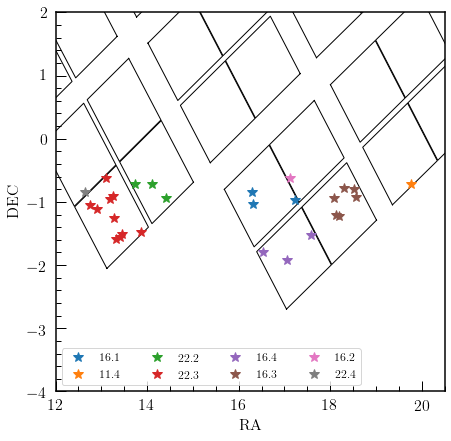

In [47]:
fig, ax = subplots(1,1)

c8fov.plot_field(ax) # plot our field again

for ccd_name, coord_list in ccd_positions.items():
    ras, decs = zip(*coord_list)
    ax.plot(ras, decs, ls=' ', marker='*', ms=10, label=ccd_name)
    
ax.legend(ncol=4)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_xlim(12, 20.5)
ax.set_ylim(-4, 2)

Lastly, we'll quickly go over a few attributes of the K2 field.

In [50]:
print c8fov.center # the center of the field
print c8fov.length # the number of individual CCD channels

{'dec': 5.2590989254251088, 'ra': 16.338186196701287}
76
(13.21342773732006, 24.337723771084242, -2.6967994617941984, 8.3543989954919269)


And quickly, as a performance test, we'll see how fast we can find the CCD numbers corresponding to all requested objects in campaign 8.  We'll use urllib2 to download the target list ccd from the Kepler website.

In [81]:
import time # for benchmarking
import urllib2 # for grabbing the target list

target_list_url = 'https://keplerscience.arc.nasa.gov/data/campaigns/c8/K2Campaign8targets.csv'
stream = urllib2.urlopen(target_list_url)
stream.readline() # get rid of header
coords_raw = (line.split(', ')[1:3] for line in stream if line)
coordinates = [map(float, t) for t in coords_raw if t[0] and t[1]]

print coordinates[0], coordinates[1],'...',coordinates[-1]
print "Found {} objects".format(len(coordinates))

[17.0400124, -2.654249] [17.116724, -2.613616] ... [15.5640755, 13.1104927]
Found 23565 objects


In [83]:
# run the benchmark
n_points = len(coordinates)
T0 = time.clock()
for ra, dec in coordinates: # match each object
    c8fov.test_point(ra, dec)
Tf = time.clock() - T0

print "Matched {} points took {} seconds".format(n_points, Tf)

Matched 23565 points took 0.535919 seconds
